# **Applicatons of RNNs - Natural Language Prediction**
 * # We now build a  Recurrent Neural Network in Keras  to predict next work in the Arthur Conan Doyle's book "The Adventures of Sherlock Holmes"

 * # First we download data (data can be found [here](https://drive.google.com/file/d/1GeUzNVqiixXHnTl8oNiQ2W3CynX_lsu2/view?usp=sharing))

In [2]:
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding
from keras.layers import Dense, Activation
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [5]:
%ls

1661-0.txt                       Lecture1_init.ipynb  Lecture8_25_ini.ipynb
Lecture10_lab.ipynb              Lecture2_init.ipynb  NWP_model_10.weights.h5
Lecture12_2025.ipynb             Lecture4_ini.ipynb   NWP_model_16.weights.h5
Lecture12_2025_rnn_w_init.ipynb  Lecture6_ini.ipynb


# **Reading the file content**

In [6]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length, number of characters:', len(text))
print(f"text[:100]:{text[:100]}")
max_size=100000
# cutting text due to memory size limitations
text = text[:max_size]
print('selected length, number of characters:', len(text))

corpus length, number of characters: 581888
text[:100]:﻿
project gutenberg's the adventures of sherlock holmes, by arthur conan doyle

this ebook is for th
selected length, number of characters: 100000


# **First we need to split and clean the text**
> * # using the function `get_words`
 * # Replace ‘–‘ with a white space so we can split words better
 * # Split words based on white space
 * # Remove all punctuation from words to reduce the vocabulary size (e.g. ‘What?’ becomes ‘What’)
 * # Remove all words that are not alphabetic to remove standalone punctuation tokens
 * # Normalize all words to lowercase to reduce the vocabulary size

In [7]:
import string
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  return words

words = get_words(text)
tot_uniq_words =  len(set(words))
print(words[:200])
print(f"Total words: {len(words)}")
print(f"Unique words: {tot_uniq_words}")

['project', 'gutenbergs', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'wwwgutenbergnet', 'title', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'author', 'arthur', 'conan', 'doyle', 'release', 'date', 'november', 'ebook', 'last', 'updated', 'may', 'language', 'english', 'character', 'set', 'encoding', 'start', 'of', 'this', 'project', 'gutenberg', 'ebook', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'produced', 'by', 'an', 'anonymous', 'project', 'gutenberg', 'volunteer', 'and', 'jose', 'menendez', 'cover', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', '

# **Once extracted the unique words, we also make a dictionary for them**
 * # each unique string is associated with a unique integer, starting from ```0``` to ```len(unique_words) - 1```




In [8]:
unique_words = [str(w) for w in np.unique(words)]
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print(len(unique_words))
print(f"Unique words:{unique_words[:20]}")
print(list(unique_word_index.items())[:20])

3021
Unique words:['a', 'abandoned', 'abbots', 'abhorrent', 'able', 'about', 'above', 'abruptly', 'absence', 'absolute', 'absolutely', 'absorb', 'abutted', 'accent', 'accomplice', 'accomplished', 'account', 'accountant', 'accustomed', 'acid']
[('a', 0), ('abandoned', 1), ('abbots', 2), ('abhorrent', 3), ('able', 4), ('about', 5), ('above', 6), ('abruptly', 7), ('absence', 8), ('absolute', 9), ('absolutely', 10), ('absorb', 11), ('abutted', 12), ('accent', 13), ('accomplice', 14), ('accomplished', 15), ('account', 16), ('accountant', 17), ('accustomed', 18), ('acid', 19)]


# **Then we need to create sequences of training data**
 * # we take ```NPREV_WORDS``` words and **predict the next one**


In [9]:
NPREV_WORDS = 5
prev_words = []
next_word = []
for i in range(len(words) - NPREV_WORDS):
    seq = words[i:i + NPREV_WORDS]
    if len(seq)!= NPREV_WORDS:
      print(len(seq))
    else:
      prev_words.append(seq)
      # the label
      next_word.append(words[i + NPREV_WORDS])
print(prev_words[0:3])
print(next_word[0:3])

[['project', 'gutenbergs', 'the', 'adventures', 'of'], ['gutenbergs', 'the', 'adventures', 'of', 'sherlock'], ['the', 'adventures', 'of', 'sherlock', 'holmes']]
['sherlock', 'holmes', 'by']


 # **Words must be represented as numerical format (integers or vectors)**
  * # We create now numpy array containing the sequences and their targets
* # we use **one-hot encoding**
  * # the position where to put a 1 is given by the integer encoding defined in the dictionary above
* # Note that other more efficient word embebddings can be defined, here we do not focus on the performance   
  * # even **labels are one-hot encoded**

In [10]:
X = np.zeros((len(prev_words), NPREV_WORDS, tot_uniq_words), dtype=bool)
Y = np.zeros((len(next_word), tot_uniq_words), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1 # position for the one-hot
    Y[i, unique_word_index[next_word[i]]] = 1

In [11]:
print(f"X[0][0]:{X[0][0]}")
print(f"Y[0][0]:{Y[0]}")
print(X.shape)

X[0][0]:[False False False ... False False False]
Y[0][0]:[False False False ... False False False]
(17099, 5, 3021)


# **Creating the model**
 * # In Keras to create a LSTM cell the class  ```LSTM``` is to be invoked. [docs](https://keras.io/api/layers/recurrent_layers/lstm/)
 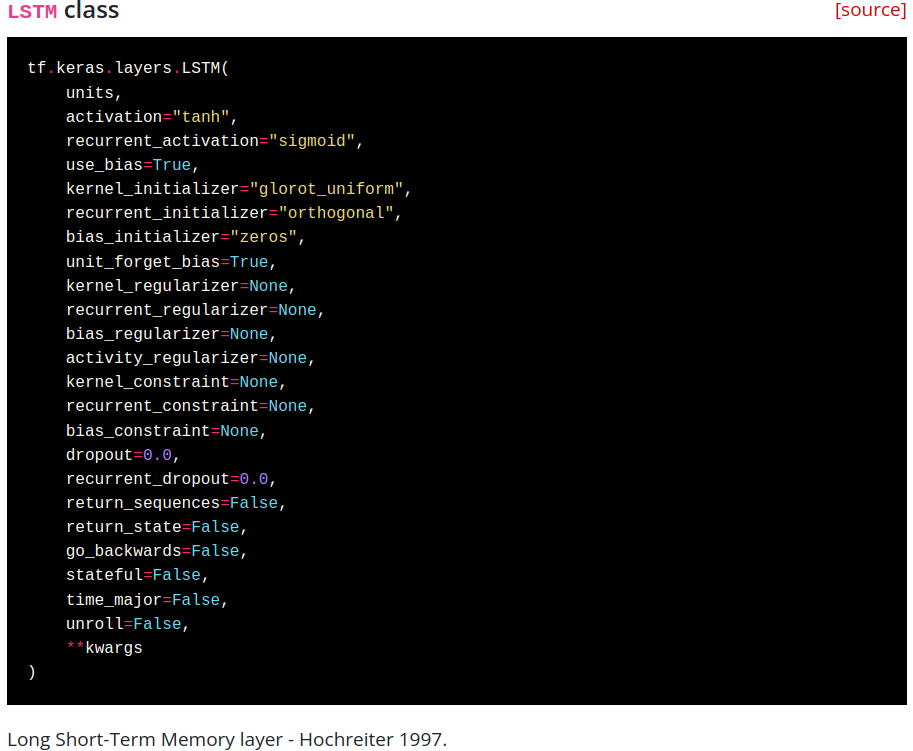


# **ARGUMENTS**
* ## All arguments contaning the substring *recurrent* refer to the hidden state ***h***
 * ## **units** is the dimension of the hidden state. So, any weight matrix in the cell ***W*** will have dimension $units\times d$, where *d* is the size of the input dimension
 * ## **return_sequences**: Boolean. Whether to return only the last output in the output sequence, or the full sequence.
 * ## **return_state**: Boolean. Whether to return the last hidden state in addition to the output
 * ## Since our problem became a **multi-class classification**, we use **cross entropy as loss**, and **softmax activation** as output with a number of units equal to the number of distinct words

In [12]:
# remind, the NPREV_WORDS we used now represent the
#   number of time steps considered in the LSTM recurrence
#   so automatically by the LSTM implementation,
#   the NPREV_WORDS words are fed to the cell one by one
model = Sequential()
model.add(LSTM(units=16, input_shape=(NPREV_WORDS, tot_uniq_words)))
# dense layer stacked atop to classify with softmax
model.add(Dense(tot_uniq_words, activation='softmax'))
print(model.summary())
# model_file = 'NWP_model_10.weights.h5'
model_file = 'NWP_model_16.weights.h5'
import os
if os.path.isfile(model_file):
  model.load_weights(model_file)
  print("file exists, loading")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │       194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3021)           │        51,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,789 (960.11 KB)

 Trainable params: 245,789 (960.11 KB)

 Non-trainable params: 0 (0.00 B)

None
file exists, loading


In [29]:
train = False
if(train):
  # training the model

  batch_size = 64
  epochs = 750
  #epochs = 150
  history = model.fit(x=X,y=Y,
            epochs=epochs,
            batch_size = batch_size,
            shuffle=True)

Epoch 1/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0388 - loss: 7.8076
Epoch 2/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0551 - loss: 6.2466
Epoch 3/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0566 - loss: 6.1770
Epoch 4/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0554 - loss: 6.1874
Epoch 5/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0555 - loss: 6.1665
Epoch 6/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0536 - loss: 6.1468
Epoch 7/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0558 - loss: 6.1487
Epoch 8/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0554 - loss: 6.1534
Epoch 9/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0549 - loss: 6.1486
Epoch 10/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0554 - loss: 6.0733
Epoch 11/750
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0539 - loss: 6.0725
Epoch 12/750
268/268 ━━━━━━━━━━━━━━━━━━━━

ValueError: The filename must end in `.weights.h5`. Received: filepath=NWP_model_16.h5

In [30]:
model_file = 'NWP_model_16.weights.h5'
# saving the trained weights
model.save_weights(model_file)

# **After an intial phase where only the loss improved, not the accuracy, suddenly the accuracy started to increase**
* ## That's typical on *memory* phenomena
* ## Increase the number of training epochs, since we did not attain a loss plateau, and also the size of the hidden state

  * 10 units, 650 epochs
    * accuracy: 0.4804 - loss: 2.4598
  * 16 units, 750 epochs
    * accuracy: 0.8536 - loss: 0.8147

# **We could even train a bit more the same model, but the loss seems satured**
* ## To improve the performance we need to increase the hidden state size

# **We now want to use the model**
> * ## the function `prepare_input` assumes we feed it with a text containing 5 words, and it will split it
> * ## Then it create the numeric 3D format to feed the model

In [13]:
# transorm the input "text" in one sample formed by its words.
#   "text" should contain NPREV_WORDS words
def prepare_input(text, NPREV_WORDS, tot_uniq_words, word_dict):
    x = np.zeros((1, NPREV_WORDS, tot_uniq_words))
    for t, word in enumerate(text.split()):
        word = word.lower()
        if word not in word_dict:
          print(f"word:{word} not in dictionary!")
          exit()
        # stop when number of time steps reached
        if t >= NPREV_WORDS:
          break
        else:
          x[0, t, word_dict[word]] = 1
    return x

# **Then we want to invoke the model to get the predicted next word**
> * ## `predict_completion` does it

In [36]:
# input text to be predicted, the dictionary of words on which the model has
# been trained
index_to_word = {i: w for w, i in unique_word_index.items()}
def predict_completion(model, text, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word):
    original_text = text
    generated = text
    next_word = ''
    x = prepare_input(text, NPREV_WORDS, tot_uniq_words, unique_word_index)
    preds = model.predict(x, verbose=0)[0]
    #print(f"preds.shape:{preds.shape}")
    # taking next word as the one with maximum probability
    #  should be extracted
    next_index = np.argmax(preds)
    next_word = index_to_word[int(next_index)]
    # next_word = list(word_dict.keys())[list(word_dict.values()).index(next_index)]
    return next_word

test = "This eBook is for the"
print(predict_completion(model, test, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word))
test = "eBook is for the use"
print(predict_completion(model, test, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word))
test = "is for the use of"
print(predict_completion(model, test, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word))
print(words[11:20])

use
of
anyone
['this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere']


# **USING THE MODEL TO RECONTRUCT A TEXT**

In [38]:
# number of words to recontstuct
recon_len = 50
ini = 190

test = words[ini:ini+NPREV_WORDS]
# concatenate string list into a text separated
test_text = " ".join(test)
print(f"initial text: {test_text}")
recon_text = []
# recontructing text with the predicted words in sequence, then compare with the true text
for i in range(recon_len):
  recon_text.append(str(predict_completion(model, test_text, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word)))
  test[:NPREV_WORDS-1] = test[1:NPREV_WORDS]
  test[NPREV_WORDS-1] = words[ini+i+NPREV_WORDS]
  test_text = " ".join(test)


print(f"real text:{words[ini+NPREV_WORDS:ini+recon_len+NPREV_WORDS]}")
print(f"recon_text:{recon_text}")

initial text: she is always the woman
real text:['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name', 'in', 'his', 'eyes', 'she', 'eclipses', 'and', 'predominates', 'the', 'whole', 'of', 'her', 'sex', 'it', 'was', 'not', 'that', 'he', 'felt', 'any', 'emotion', 'akin', 'to', 'love', 'for', 'irene', 'adler', 'all', 'emotions', 'and', 'that', 'one', 'particularly', 'were', 'abhorrent', 'to', 'his', 'cold', 'precise', 'but']
recon_text:['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'assistant', 'that', 'a', 'eyes', 'is', 'has', 'and', 'predominates', 'the', 'whole', 'of', 'her', 'sex', 'it', 'was', 'not', 'that', 'he', 'shall', 'an', 'emotion', 'akin', 'to', 'love', 'for', 'irene', 'adler', 'all', 'emotions', 'and', 'that', 'one', 'woman', 'were', 'abhorrent', 'to', 'his', 'one', 'precise', 'but']


# **The quality of predictions is not so good**
* ## An error soon is propagated forever
* ## Need to better tune the model and increase the model size

In [ ]:
drive.flush_and_unmount()

# **EXERCISE**
 * ## After having tuned a better model, even running the same fit() without reinitialing the model, try to call the prediction_completion method in a loop scanning the whole text, and computing fraction of correct prediction
 * ## Repeat the experiment by varying NPREV_WORDS, e.g., to 3 and to 7, to check whether the model predictive capabilities change  

In [39]:
correct_predictions = 0
total_predictions = 0

for i in range(len(words) - NPREV_WORDS):
    input_seq = " ".join(words[i:i + NPREV_WORDS])
    true_next_word = words[i + NPREV_WORDS]

    pred_word = predict_completion(model, input_seq, NPREV_WORDS, tot_uniq_words, unique_word_index, index_to_word)

    if pred_word == true_next_word:
        correct_predictions += 1
    total_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy over the text: {accuracy:.4f}")


Progress: 0/17104
Progress: 1000/17104
Progress: 2000/17104
Progress: 3000/17104
Progress: 4000/17104
Progress: 5000/17104


KeyboardInterrupt: 

In [ ]:
X_eval = np.zeros((len(words) - NPREV_WORDS, NPREV_WORDS, tot_uniq_words), dtype=bool)

for i in range(len(words) - NPREV_WORDS):
    seq = words[i:i + NPREV_WORDS]
    for j, word in enumerate(seq):
        if word in unique_word_index:
            X_eval[i, j, unique_word_index[word]] = 1
        else:
            print(f"Warning: Word '{word}' not found in dictionary. Skipping.")  # optional warning

# Predict all at once
print("Predicting in batch...")
Y_pred = model.predict(X_eval, batch_size=128, verbose=1)

# Evaluate accuracy
correct_predictions = 0

for i in range(len(words) - NPREV_WORDS):
    true_word = words[i + NPREV_WORDS]
    pred_index = np.argmax(Y_pred[i])
    pred_word = index_to_word.get(int(pred_index), None)  # Safe lookup

    if pred_word == true_word:
        correct_predictions += 1

accuracy = correct_predictions / (len(words) - NPREV_WORDS)
print(f"\n Final Accuracy (5 words) over the full text: {accuracy:.4f}")


Predicting in batch...
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 Final Accuracy (5 words) over the full text: 0.8602


16 units, 5 words : Accuracy over the text: 0.8602

In [42]:
model_3 = Sequential()
model_3.add(LSTM(units=16, input_shape=(3, tot_uniq_words)))
model_3.add(Dense(tot_uniq_words, activation='softmax'))
print(model_3.summary())
model_file = "NWP_model_16_nprev_3.h5"

model_3.load_weights(model_file)
print("file exists, loading")
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │       194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3021)           │        51,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,789 (960.11 KB)

 Trainable params: 245,789 (960.11 KB)

 Non-trainable params: 0 (0.00 B)

None
file exists, loading


In [43]:
NPREV_WORDS = 3
X_eval = np.zeros((len(words) - NPREV_WORDS, NPREV_WORDS, tot_uniq_words), dtype=bool)

for i in range(len(words) - NPREV_WORDS):
    seq = words[i:i + NPREV_WORDS]
    for j, word in enumerate(seq):
        if word in unique_word_index:
            X_eval[i, j, unique_word_index[word]] = 1
        else:
            print(f"Warning: Word '{word}' not found in dictionary. Skipping.")  # optional warning

# Predict all at once
print("Predicting in batch...")
Y_pred = model.predict(X_eval, batch_size=128, verbose=1)

# Evaluate accuracy
correct_predictions = 0

for i in range(len(words) - NPREV_WORDS):
    true_word = words[i + NPREV_WORDS]
    pred_index = np.argmax(Y_pred[i])
    pred_word = index_to_word.get(int(pred_index), None)  # Safe lookup

    if pred_word == true_word:
        correct_predictions += 1

accuracy = correct_predictions / (len(words) - NPREV_WORDS)
print(f"\n Final Accuracy over the full text: {accuracy:.4f}")


Predicting in batch...
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 Final Accuracy over the full text: 0.0568


In [45]:
model_7 = Sequential()
model_7.add(LSTM(units=16, input_shape=(3, tot_uniq_words)))
model_7.add(Dense(tot_uniq_words, activation='softmax'))
print(model_7.summary())
model_file = "NWP_model_16_nprev_7.h5"
model_7.load_weights(model_file)
print("file exists, loading")
model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 16)             │       194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3021)           │        51,357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,789 (960.11 KB)

 Trainable params: 245,789 (960.11 KB)

 Non-trainable params: 0 (0.00 B)

None
file exists, loading


In [46]:
NPREV_WORDS = 7
X_eval = np.zeros((len(words) - NPREV_WORDS, NPREV_WORDS, tot_uniq_words), dtype=bool)

for i in range(len(words) - NPREV_WORDS):
    seq = words[i:i + NPREV_WORDS]
    for j, word in enumerate(seq):
        if word in unique_word_index:
            X_eval[i, j, unique_word_index[word]] = 1
        else:
            print(f"Warning: Word '{word}' not found in dictionary. Skipping.")  # optional warning

# Predict all at once
print("Predicting in batch...")
Y_pred = model.predict(X_eval, batch_size=128, verbose=1)

# Evaluate accuracy
correct_predictions = 0

for i in range(len(words) - NPREV_WORDS):
    true_word = words[i + NPREV_WORDS]
    pred_index = np.argmax(Y_pred[i])
    pred_word = index_to_word.get(int(pred_index), None)  # Safe lookup

    if pred_word == true_word:
        correct_predictions += 1

accuracy = correct_predictions / (len(words) - NPREV_WORDS)
print(f"\n Final Accuracy (7 words) over the full text: {accuracy:.4f}")


Predicting in batch...
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 Final Accuracy (7 words) over the full text: 0.0705


## Final results:

* With 5 words: 0.8602

* With 3 words: 0.0568

* With 7 words:0.0705